In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import zarr
import plotter as plo
from cmcrameri import cm
import pywtt as pw
import scipy.stats
from matplotlib.gridspec import GridSpec
import matplotlib
import CHONK_XL as chxl
from cmcrameri import cm
from matplotlib.gridspec import GridSpec
from scipy import stats

matplotlib.rc('font', family='Helvetica Neue') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rcParams.update({'font.size': 16})

%matplotlib widget
def divide_labels(ax, divider, isint = True, axis = "both"):
    if(axis == "both"):
        onx = True
        ony = True
    elif (axis == "x"):
        onx = True
        ony = False
    elif (axis == "y"):
        onx = False
        ony = True
            
    
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    xtickslab = ax.get_xticklabels()
    ytickslab = ax.get_yticklabels()
    if(onx):
        for i in range(len(xticks)):
            xtickslab[i] = str(int(xticks[i]/divider)) if isint else str(xticks[i]/divider)
        ax.set_xticklabels(xtickslab)
    
    if(ony):
        for i in range(len(yticks)):
            ytickslab[i] = str(int(yticks[i]/divider)) if isint else str(yticks[i]/divider)
        ax.set_yticklabels(ytickslab)

In [2]:
ds = xr.open_zarr('section_tooleffect.zarr')
ds.x.values[0] = 0
ds.y.values[0] = 0
ny = ds.ChonkBase__ny.item(0)
nx = ds.ChonkBase__nx.item(0)
dx = ds.ChonkBase__dx.item(0)
dy = ds.ChonkBase__dy.item(0)

extent = [ds.x.min(),ds.x.max(),ds.y.min(), ds.y.max() ]



In [13]:
# Getting the original topo
# input(0)
Ath = 1e7
original = pw.minigraph( nx,  ny,  nx * ny,  dx,  dy, 0, 0, ds.sel({"batch":1}).sel({"otime":0}, method = "nearest").Topography__topography.values.ravel())
# input(1)
original.set_default_boundaries("periodic_EW")
# input(2)
original.compute_graph("simple")
# input(3)
original.calculate_area()
# input(4)
original.d_sources(Ath)
# input(5)
original.compute_all_basins()
# input(6)
original.compute_river_nodes()
# input(7)
original.calculate_junction_map()
# yolo = original.get_rivers_rowcolnode()
oriv1 = original.get_rivers_dict()
oriv2 = original.get_rivers_rowcolnode()
oriv = oriv1.copy()
oriv.update(oriv2)
oriv["basin"] = original.get_rivers_basin_label()
# input(10)
oriv["SO"] = original.get_stream_order()
oriv["basarr"] = original.get_basin_array()

JD = original.get_junction_map()







Ath is 1e+07
Got 1432 river pixels, I had 48 sources
stuffy1


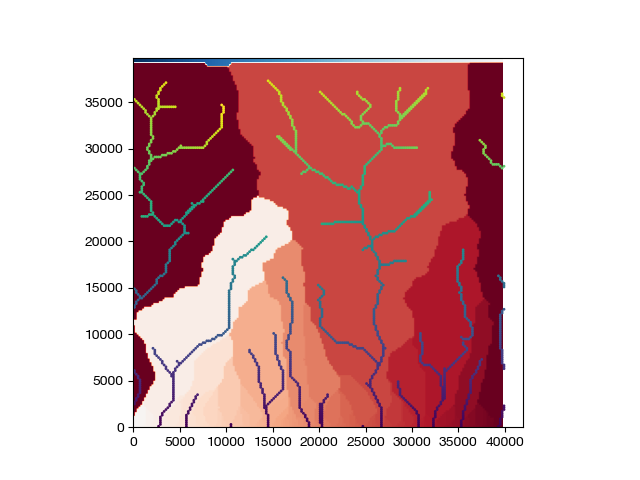

In [14]:
fig, ax = plt.subplots()
geol = np.load("geological_map.npy")
ax.imshow(original.get_topo_np().reshape(ny,nx), extent = extent, cmap = "gray")
cb = ax.imshow(oriv["basarr"].reshape(ny,nx), extent = extent, cmap = "RdBu_r")
# ax.imshow(geol, extent = extent, cmap = "jet")
# ax.scatter(oriv["X"], oriv["Y"], c =  "b", lw =0, s = 4)
# ax.scatter(oriv["X"], oriv["Y"], c =  np.log10(oriv["A"]), lw =0, s = 4)
# ax.scatter(dfo["X"], dfo["Y"], c = dfo["flow_distance"], lw =0, s = 4)
ax.scatter(oriv["X"], oriv["Y"], c = oriv["flow_distance"], lw =0, s = 4)
# cb = ax.scatter(JD["X"], JD["Y"],c = 'k', lw =2, s = 40, marker = "x")

# plt.colorbar(cb)


In [20]:
# import pandas as pd
# oriv.pop("basarr",None)
# df = pd.DataFrame(oriv)
# df = df[df["basin"] == 333]

# df = df.to_csv("oriv.csv", index = False)

# oriv = original.get_full_rivers_of_basin(333)
# note = original.get_full_rivers_of_basin(341)
# te =  original.get_full_rivers_of_basin(333)
# import pickle
# with open('oriv.pickle', 'wb') as handle:
#     pickle.dump(oriv, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('te.pickle', 'wb') as handle:
#     pickle.dump(te, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('note.pickle', 'wb') as handle:
#     pickle.dump(note, handle, protocol=pickle.HIGHEST_PROTOCOL)

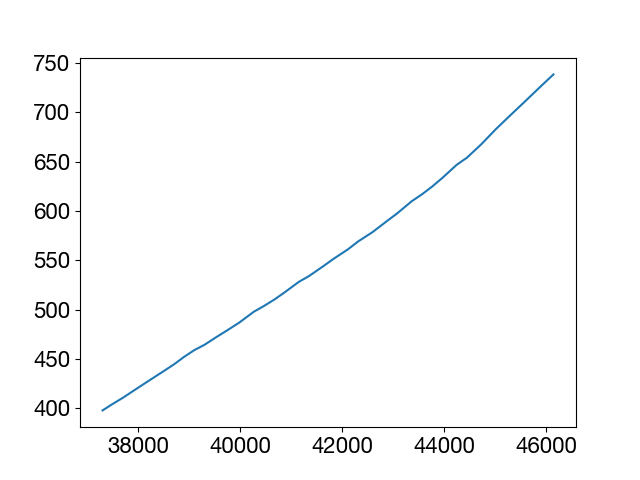

In [26]:
dfo = pd.read_csv("oriv.csv")
dfte = pd.read_csv("TE4Myrs.csv")
dfnote = pd.read_csv("NoTE4Myrs.csv")
dfo_full = pd.read_csv("oriv_full.csv")
dfte_full = pd.read_csv("TE5Myrs_full.csv")
dfnote_full = pd.read_csv("NoTE5Myrs_full.csv")

# for tdf in [dfo, dfte, dfnote]:
tsk = dfo["key"][dfo["flow_distance"] == dfo["flow_distance"].max()].values[0]
dfo = dfo[dfo["key"] == tsk]
tsk = dfte["key"][dfte["flow_distance"] == dfte["flow_distance"].max()].values[0]
dfte = dfte[dfte["key"] == tsk]
tsk = dfnote["key"][dfnote["flow_distance"] == dfnote["flow_distance"].max()].values[0]
dfnote = dfnote[dfnote["key"] == tsk]

cmap = matplotlib.cm.get_cmap('Spectral')

norm = matplotlib.colors.Normalize(vmin=dfo["key"].min(), vmax=dfo["key"].max())

rgba = cmap(0.5)


fig,ax = plt.subplots()
ax.plot(dfo.flow_distance,dfo.Z)   

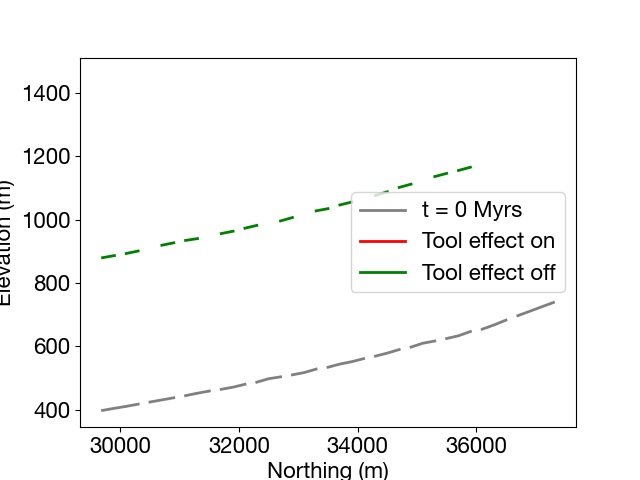

In [27]:
tYk = "Y"
fig,ax = plt.subplots()
Xso = stats.binned_statistic(dfo[tYk].values, dfo[tYk].values, 'median', bins=50).statistic
Zso = stats.binned_statistic(dfo[tYk].values, dfo.Z.values, 'min', bins=50).statistic
Xste = stats.binned_statistic(dfte[tYk].values, dfte[tYk].values, 'median', bins=50).statistic
Zste = stats.binned_statistic(dfte[tYk].values, dfte.Z.values, 'min', bins=50).statistic
Xsnote = stats.binned_statistic(dfnote[tYk].values, dfnote[tYk].values, 'median', bins=50).statistic
Zsnote = stats.binned_statistic(dfnote[tYk].values, dfnote.Z.values, 'min', bins=50).statistic

ax.plot(Xso,Zso, c = "gray", lw = 2, label = "t = 0 Myrs")
ax.plot(Xste,Zste, c = "r", lw = 2, label = "Tool effect on")
ax.plot(Xsnote,Zsnote, c = "g", lw = 2, label = "Tool effect off")
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Elevation (m)")
ax.legend()

KeyError: 'flow_distance'

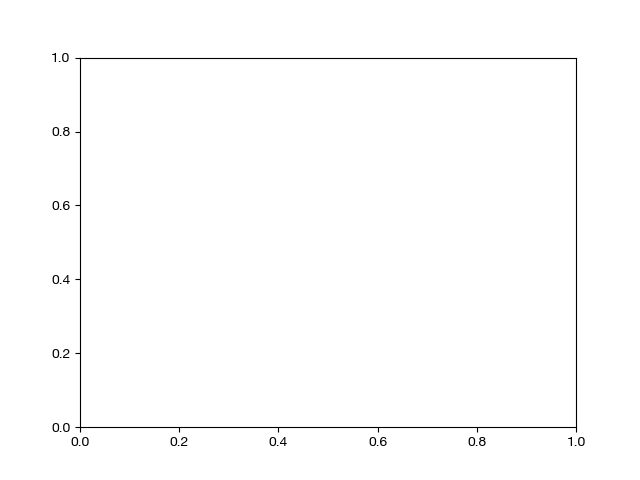

In [21]:
tYk = "flow_distance"
geol = np.load("geological_map.npy")
# oriv["geol"] = geol[dfo["row"].values,dfo["col"].values]
with open('oriv.pickle', 'rb') as handle:
    oriv = pickle.load(handle)
with open('note.pickle', 'rb') as handle:
    note = pickle.load(handle)
with open('te.pickle', 'rb') as handle:
    te = pickle.load(handle)

    
#NEED TO START HERE
    
fig,ax = plt.subplots()
Xso = stats.binned_statistic(oriv[tYk].values, oriv[tYk].values, 'median', bins=50).statistic
Zso = stats.binned_statistic(oriv[tYk].values, oriv.Z.values, 'min', bins=50).statistic
geolso = stats.binned_statistic(oriv[tYk].values, oriv.geol.values, lambda x: x[x == 1].shape[0]/x.shape[0], bins=50).statistic
Xste = stats.binned_statistic(te[tYk].values, te[tYk].values, 'median', bins=50).statistic
Zste = stats.binned_statistic(te[tYk].values, te.Z.values, 'min', bins=50).statistic
Xsnote = stats.binned_statistic(note[tYk].values, note[tYk].values, 'median', bins=50).statistic
Zsnote = stats.binned_statistic(note[tYk].values, note.Z.values, 'min', bins=50).statistic
Zsomax = stats.binned_statistic(oriv[tYk].values, oriv.Z.values, 'median', bins=50).statistic
Zstemax = stats.binned_statistic(te[tYk].values, te.Z.values, 'median', bins=50).statistic
Zsnotemax = stats.binned_statistic(note[tYk].values, note.Z.values, 'median', bins=50).statistic

# Xso = Xso/Xso.max()
# Xste = Xste/Xste.max()
# Xsnote = Xsnote/Xsnote.max()

ax.plot(Xso,Zso, c = "gray", lw = 2, label = "t = 0 Myrs")
# ax.plot(Xso,Zsomax, c = "gray", lw = 1, ls = '--')
ax.plot(Xste,Zste, c = "r", lw = 2, label = "Tool effect on")
# ax.plot(Xso,Zstemax, c = "r", lw = 1, ls = '--')
ax.plot(Xsnote,Zsnote, c = "g", lw = 2, label = "Tool effect off")
# ax.plot(Xso,Zsnotemax, c = "g", lw = 1, ls = '--')
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Normalised distance from outlet")
ax.legend()
xticks = ax.get_xticks()[1:-1] #< notice the slicing
yticks = ax.get_yticks()[1:-1] #< notice the slicing
xgrid, ygrid = np.meshgrid(xticks, yticks)
ax.scatter(xgrid,ygrid, marker= "+",c = 'k', s = 20, lw = 1 , alpha = 0.4, zorder = 5)

# ax2 = ax.twinx()
# ax2.plot(Xso[geolso>0],geolso[geolso>0])

In [5]:
from ipyfastscape import TopoViz3d


app = TopoViz3d(ds, canvas_height=600, time_dim="otime", elevation_var = "Topography__topography" )

app.show()

Output(layout=Layout(height='640px'))

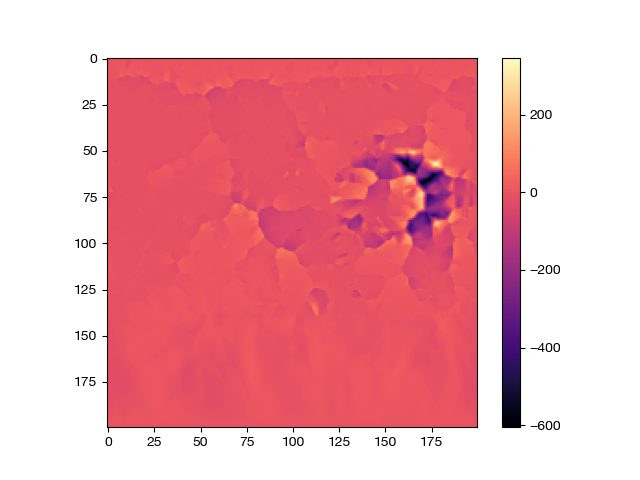

In [26]:
diff = ds.sel({"batch":0}).isel({"otime":-1}).Topography__topography.values - ds.sel({"batch":1}).isel({"otime":-1}).Topography__topography.values
fig, ax = plt.subplots()
cb = ax.imshow(diff,cmap = "magma")
plt.colorbar(cb)

In [29]:
ds.sel({"batch":0}).Fluvial__relative_erosivity_bed.values

array(True)

In [7]:
oriv

{'Y': array([ 9500.,  9300.,  9100., ..., 17500., 17500., 17500.], dtype=float32),
 'X': array([39300., 39300., 39300., ..., 27100., 26900., 26700.], dtype=float32),
 'Z': array([ 41.727108,  40.84649 ,  39.9776  , ..., 155.85518 , 143.72981 ,
        133.44733 ], dtype=float32),
 'flow_distance': array([9648.528 , 9448.528 , 9248.528 , ...,  682.8427,  482.8427,
         282.8427], dtype=float32),
 'A': array([10120000., 10480000., 10800000., ..., 22440000., 22520000.,
        22600000.], dtype=float32),
 'row': array([152, 153, 154, ..., 112, 112, 112], dtype=int32),
 'col': array([196, 196, 196, ..., 135, 134, 133], dtype=int32),
 'node': array([30596, 30796, 30996, ..., 22535, 22534, 22533], dtype=int32),
 'rivrec': array([   1,    2,    3, ..., 1318, 1319, 1043], dtype=int32),
 'globrec': array([30796, 30996, 31196, ..., 22534, 22533, 22732], dtype=int32),
 'basin': array([399, 399, 399, ..., 199, 199, 199], dtype=int32),
 'SO': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'basar